# install the current spatialist and pyroSAR development branch

```shell
sudo apt-get install git
python -m pip install git+https://github.com/johntruckenbrodt/spatialist.git@master
python -m pip install git+https://github.com/johntruckenbrodt/pyroSAR.git@feature/gamma_export_demproducts
```

# download test data

```shell
wget -c -T120 --no-check-certificate --user="username" --password="password" \
-O S1A_IW_GRDH_1SDV_20180829T170656_20180829T170721_023464_028DE0_F7BD.zip \
"https://scihub.copernicus.eu/dhus/odata/v1/Products('1d498b6b-f890-4c3f-a30e-877338e9f2fe')/\$value"
```

# prepare several DEM files in Gamma format for a Sentinel-1 scene

documentation:
- [pyroSAR.identify](https://pyrosar.readthedocs.io/en/latest/pyroSAR.html#pyroSAR.drivers.identify)
- function dem_autocreate is not documented on readthedocs yet, but a docstring can be called in Python: `help(dem_autocreate)`
- the download of TanDEM-X 90m DEMs requires a registration, see [here](https://geoservice.dlr.de/web/dataguide/tdm90) for details; once registered the credentials can be passed to function dem_autocreate; for the other DEM options they are ignored

In [1]:
import os
import pyroSAR
from pyroSAR import identify
from pyroSAR.gamma.srtm import dem_autocreate

maindir = '/home/john/Desktop/S1_ARD'

filename = os.path.join(maindir, 'S1A_IW_GRDH_1SDV_20180829T170656_20180829T170721_023464_028DE0_F7BD.zip')

id = identify(filename)

demfiles = {}
for demType in ['AW3D30', 'SRTM 1Sec HGT', 'SRTM 3Sec', 'TDX90m']:
    dem_id = demType.replace(' ', '-')
    dem_base = 'demfile_gamma_{}'.format(dem_id)
    dem = os.path.join(maindir, dem_base)
    print(demType)
    with id.bbox() as bbox:
        dem_autocreate(geometry=bbox, demType=demType, outfile=dem, 
                       username='username', password='password')
    demfiles[dem_id] = dem

/usr/local/lib/python3.6/dist-packages/pyroSAR/__init__.py
AW3D30
outfile already exists
SRTM 1Sec HGT
outfile already exists
SRTM 3Sec
outfile already exists
TDX90m
outfile already exists


# process the scene with the different DEMs in Gamma

documentation:
- [pyroSAR.gamma.geocode](https://pyrosar.readthedocs.io/en/latest/pyroSAR.html#pyroSAR.gamma.geocode)

In [2]:
from pyroSAR.gamma import geocode

# parallelize the Gamma commands
os.environ['OMP_NUM_THREADS'] = '6'

for dem_id, dem_file in demfiles.items():
    scenedir = os.path.join(maindir, '{}_{}'.format(id.outname_base(), dem_id))
    geocode(scene=id, dem=dem_file,
            tempdir=os.path.join(scenedir, 'process'), outdir=scenedir,
            targetres=90, scaling='db')

scene S1A__IW___A_20180829T170656 already processed
scene S1A__IW___A_20180829T170656 already processed
scene S1A__IW___A_20180829T170656 already processed
scene S1A__IW___A_20180829T170656 already processed


# compare backscatter with local incidence angle

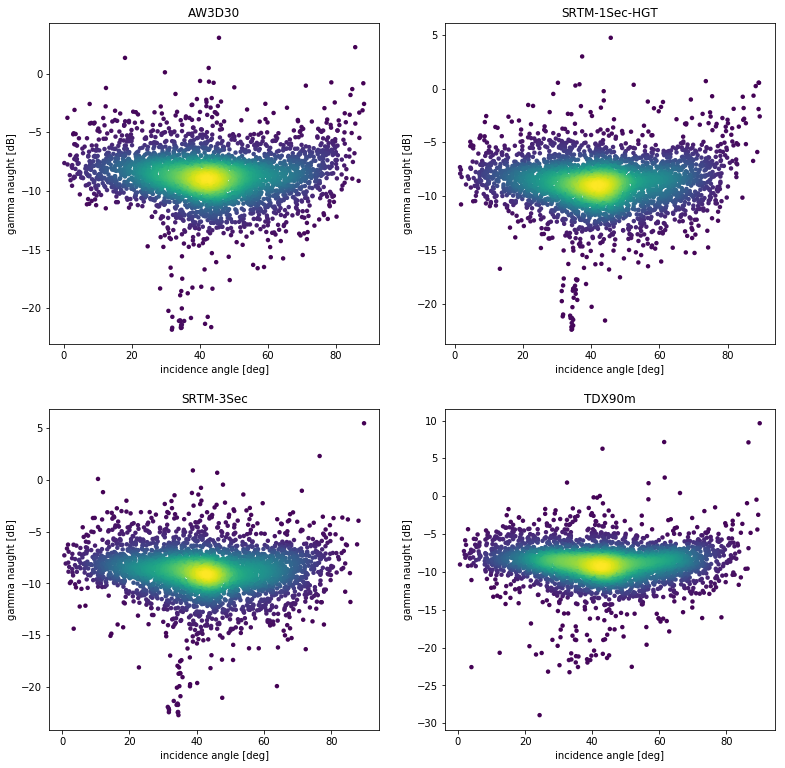

In [7]:
% matplotlib inline

from S1_ARD import sar_vs_inc
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (13, 13)

i = 1
for dem_id in demfiles.keys():
    scenedir = os.path.join(maindir, '{}_{}'.format(id.outname_base(), dem_id))
    sar = os.path.join(scenedir, '{}_VV_grd_mli_norm_geo_db.tif'.format(id.outname_base()))
    inc = os.path.join(scenedir, '{}_inc_geo.tif'.format(id.outname_base()))
    plt.subplot(2, 2, i)
    sar_vs_inc(sar, inc, nsamples=5000, title=dem_id, 
               xlabel='incidence angle [deg]', 
               ylabel='gamma naught [dB]')
    i += 1
plt.show()